# DAML Sem 2, Week 9, CP14: Lepton energy reconstruction in water Cerenkov detectors: NN Regression and Gradient Boosted Regression Trees

In [23]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection 

## Data inspection and variable plotting

### Exercise \#1

data from https://cernbox.cern.ch/index.php/s/BYbIDPZY3bSRKJC

In [4]:
# Read csv data form file
file_data = pd.read_csv('numu_energy_studies.csv').iloc[:, 1:]

In [5]:
# Check dataframe looks as expected
file_data

,i,neutrinoE,trueKE,recoE_lookup,total_PMTs_hits2,total_hits2,total_ring_PEs2,pot_length2,hits_pot_length2,recoDWallR2,recoDWallZ2,lambda_max_2,recoDWall_2,recoToWall_2,vtxTrackBias_2
0,0,664.541,236.327,22.35380,0.000000,0.023325,0.00000,0.662787,0.003754,0.003389,0.458415,0.650854,0.003389,0.220977,-0.011905
1,3,400.551,186.765,2.46971,0.000000,0.010075,0.00000,0.662787,0.001621,0.003389,0.458415,0.405903,0.003389,0.220977,-2.269040
2,4,633.353,448.481,409.95400,0.308444,0.080400,0.13070,0.531171,0.016146,0.035389,0.753969,0.537975,0.035389,0.494926,0.024453
3,7,845.921,586.647,37.83740,0.000000,0.011950,0.00000,0.918554,0.001388,0.042498,0.083664,0.830098,0.042498,0.805578,-0.007114
4,9,1323.140,963.822,1408.07000,0.111333,0.142300,0.26265,0.093641,0.162093,0.616305,0.164307,0.092105,0.358487,0.135845,-0.004307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166181,4992,667.212,356.525,327.70500,0.179556,0.056000,0.07730,0.299882,0.019919,0.524681,0.094948,0.293151,0.207160,0.299882,0.010166
166182,4994,298.731,92.382,11.75980,0.000000,0.009150,0.00000,0.237723,0.004106,0.435005,0.604201,0.264387,0.435005,0.237723,-0.034267
166183,4998,2847.440,2464.460,1159.19000,0.142222,0.147675,0.23995,0.012261,1.284710,-0.046764,0.413032,0.402720,-0.046764,0.314218,-0.001124
166184,4999,754.128,480.235,447.62300,0.144444,0.081425,0.13985,0.080920,0.107332,0.157146,0.330336,0.175398,0.157146,0.080920,0.043704


Looks alright.

In [8]:
# The features we're interested in given in notes
features_interest = ['total_hits2', 'total_ring_PEs2', 'recoDWallR2', 'recoDWallZ2', 'lambda_max_2',
                     'trueKE']

In [9]:
# New DataFrame with just features of interest
fileDF = file_data[features_interest]

In [12]:
fileDF

,total_hits2,total_ring_PEs2,recoDWallR2,recoDWallZ2,lambda_max_2,trueKE
0,0.023325,0.00000,0.003389,0.458415,0.650854,236.327
1,0.010075,0.00000,0.003389,0.458415,0.405903,186.765
2,0.080400,0.13070,0.035389,0.753969,0.537975,448.481
3,0.011950,0.00000,0.042498,0.083664,0.830098,586.647
4,0.142300,0.26265,0.616305,0.164307,0.092105,963.822
...,...,...,...,...,...,...
166181,0.056000,0.07730,0.524681,0.094948,0.293151,356.525
166182,0.009150,0.00000,0.435005,0.604201,0.264387,92.382
166183,0.147675,0.23995,-0.046764,0.413032,0.402720,2464.460
166184,0.081425,0.13985,0.157146,0.330336,0.175398,480.235


In [11]:
fileDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166186 entries, 0 to 166185
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   total_hits2      166186 non-null  float64
 1   total_ring_PEs2  166186 non-null  float64
 2   recoDWallR2      166186 non-null  float64
 3   recoDWallZ2      166186 non-null  float64
 4   lambda_max_2     166186 non-null  float64
 5   trueKE           166186 non-null  float64
dtypes: float64(6)
memory usage: 7.6 MB


No columns have any null values so no cleaning required.

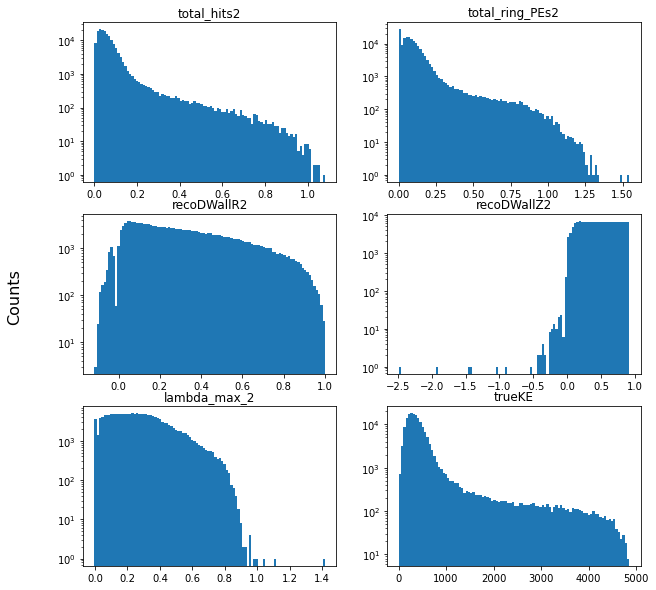

In [18]:
# Plot feature distributions
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.supylabel('Counts', fontsize=16)
n_bins = 100
feat = 0
for i in range(len(axs)):
    for j in range(len(axs[0])):  
        axs[i, j].hist(fileDF[features_interest[feat]],
                       bins=n_bins, density=False, alpha=1.0, log=True)
        axs[i, j].set_title(features_interest[feat])
        feat += 1
plt.show()

## NN regression

### Exercise \#2

In [25]:
# Sort into features and target
input_data = fileDF.iloc[:, :-1]
target = fileDF.iloc[:, -1]

Answer_to_all_questions = 42
# train - test split of dataset
train_data, test_data, train_target, test_target = model_selection.train_test_split(\
    input_data, target, test_size = 0.3, random_state = Answer_to_all_questions)
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(116330, 5) (116330,) (49856, 5) (49856,)


In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import dt_utils
import nn_utils

ModuleNotFoundError: No module named 'sklearn.externals.six'

In [39]:
num_inputs = 5; num_outputs = 1
num_nodes = num_inputs

In [47]:
# A simple NN
def my_model():
    # create model
    model = Sequential()
    model.add(Dense(4*num_nodes, input_dim = num_inputs, kernel_initializer = 'normal' , \
    activation = 'relu'))
    model.add(Dense(2*num_nodes, input_dim = 4*num_nodes, kernel_initializer = 'normal' , \
    activation = 'relu'))
    # Dropout layer to try to discourage overfitting to training data
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer = 'normal'))
    # Compile model
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

In [48]:
callbacks_ = [
# if we don ’t have an increase of the accuracy for 10 epochs , terminate training .
EarlyStopping(verbose = True, patience =10, monitor = 'loss'),
# Always make sure that we ’ re saving the model weights with the best accuracy .
ModelCheckpoint('model.h5', monitor = 'loss' , verbose =0 , save_best_only = True , mode = 'max')]

In [49]:
# Same pipeline method as a revious CP
batchSize = 100
N_epochs = 20
np.random.seed(Answer_to_all_questions)
from sklearn.pipeline import Pipeline
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn = my_model , epochs = N_epochs,
batch_size = batchSize , verbose =0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits =10, random_state = Answer_to_all_questions , shuffle = True )
results = cross_val_score(pipeline , input_data , target , cv = kfold ,
fit_params = { 'mlp__callbacks': callbacks_ } , scoring = 'r2')
print( "Result: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

Result: 0.72 ± 0.01


R^2 score is acceptable.

In [51]:
model1 = my_model() 

In [52]:
history = model1.fit(train_data, train_target, batch_size = batchSize, epochs = N_epochs, \
    verbose =1, validation_data =(test_data, test_target))

Epoch 1/20
1164/1164 [==============================] - 3s 2ms/step - loss: 463350.2500 - val_loss: 296186.2500
Epoch 2/20
1164/1164 [==============================] - 2s 2ms/step - loss: 249242.2188 - val_loss: 167444.5781
Epoch 3/20
1164/1164 [==============================] - 3s 2ms/step - loss: 150153.0625 - val_loss: 114370.6172
Epoch 4/20
1164/1164 [==============================] - 2s 2ms/step - loss: 134796.5625 - val_loss: 110737.2188
Epoch 5/20
1164/1164 [==============================] - 2s 2ms/step - loss: 133510.4062 - val_loss: 110766.6328
Epoch 6/20
1164/1164 [==============================] - 3s 2ms/step - loss: 134620.7344 - val_loss: 110901.7812
Epoch 7/20
1164/1164 [==============================] - 3s 2ms/step - loss: 133705.4062 - val_loss: 110609.7266
Epoch 8/20
1164/1164 [==============================] - 3s 2ms/step - loss: 133471.8750 - val_loss: 110952.8906
Epoch 9/20
1164/1164 [==============================] - 3s 2ms/step - loss: 132889.6562 - val_loss: 1104

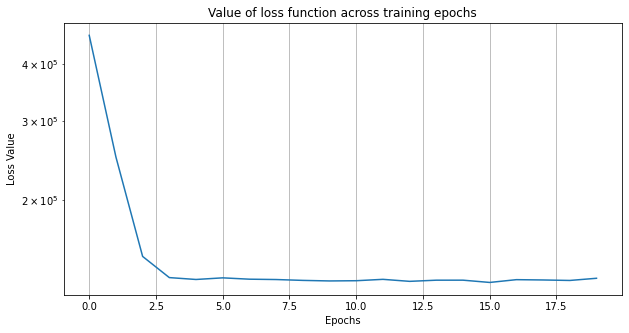

In [79]:
nn_utils.lossplot(history.history['loss'], scale='log')

Loss curve plateaus as we expect.

In [54]:
predicted = model1.predict(test_data)

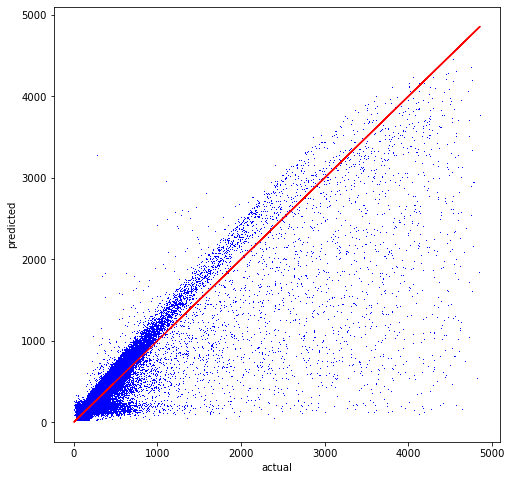

In [55]:
# 
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(test_target, predicted, ',b')
# Lay on top ideal line of true = predicted
ax.plot(test_target, test_target, '-r')
ax.set_xlabel('actual')
ax.set_ylabel('predicted')
plt.show()

Most points are scattered around the ideal red line. A dense group just above red line where the model slightly overestimates the energies and a less dense cloud below red line means model often underestimates the energies.

## Gradient Boosted Regression Trees

### Exercise \#3

In [66]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

In [59]:
# From notes
gbr0 = GradientBoostingRegressor(n_estimators =100)
gbr0.fit(train_data, train_target.ravel())

GradientBoostingRegressor()

In [60]:
R2_train = gbr0.score(train_data, train_target)
R2_test = gbr0.score(test_data, test_target)

In [61]:
print('R^2 score (training):', R2_train)
print('R^2 score (test):', R2_test)

R^2 score (training): 0.7802986279228536
R^2 score (test): 0.7724637579059646


Similar scores for both training and test datasets so model generalises reasonably well to unknown data (no evidence of overfitting). Both scores are improvements over the NN regressor by ~0.05.

In [69]:
param_grid_ = {
    'n_estimators' :[100] ,
    'learning_rate' : [0.1 , 0.05] ,
    'max_depth' :[5 , 10] ,
    'min_samples_leaf' :[50 ,100] ,
    }
njobs_ =8 # jobs to run in parallel
np.random.seed(Answer_to_all_questions)
gbr = GradientBoostingRegressor()
# Try the halfgridsearch for a speed up
classifier = HalvingGridSearchCV(estimator = gbr , cv = kfold , param_grid = param_grid_ ,
n_jobs = njobs_ , verbose =1, random_state=Answer_to_all_questions)
classifier.fit(train_data , train_target.ravel())
print("Best estimator: ")
print(classifier.best_estimator_)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 38776
max_resources_: 116330
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 38776
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 3
n_resources: 116328
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best estimator: 
GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=50)


In [85]:
from sklearn.model_selection import learning_curve

In [86]:
# Was using the nn_utils.py from a previous CP which didn't have plot_learning_curve() by mistake, so copied it here instead
# because I think I would need to restart kernel for it to find the new file with the same name, maybe
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """ Generate a simple plot of the test and traning learning curve.
    
    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
    An object of that type which is cloned for each validation.
    
    title : string
    Title for the chart.
    
    X : array-like, shape (n_samples, n_features)
    Training vector, where n_samples is the number of samples and
    n_features is the number of features.
    
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
    Target relative to X for classification or regression;
    None for unsupervised learning.
    
    ylim : tuple, shape (ymin, ymax), optional
    Defines minimum and maximum yvalues plotted.
    
    cv : integer, cross-validation generator, optional
    If an integer is passed, it is the number of folds (defaults to 3).
    Specific cross-validation objects can be passed, see
    sklearn.cross_validation module for the list of possible objects
    
    n_jobs : integer, optional
    Number of jobs to run in parallel (default 1).
    """
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Matthew\\Anaconda3\\envs\\daml2\\lib\\site-packages\\matplotlib\\pyplot.py'>

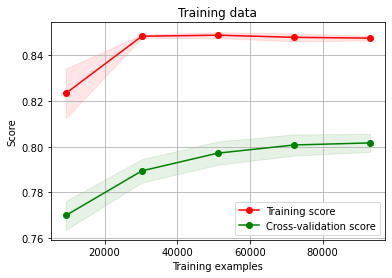

In [87]:
plot_learning_curve(classifier.best_estimator_, 'Training data', train_data, train_target)

Performance improves with more training examples as expected.

<module 'matplotlib.pyplot' from 'C:\\Users\\Matthew\\Anaconda3\\envs\\daml2\\lib\\site-packages\\matplotlib\\pyplot.py'>

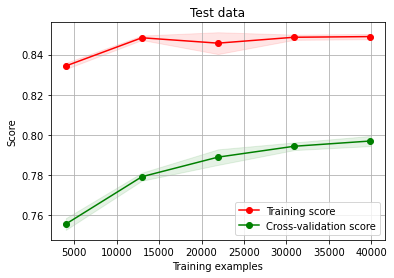

In [88]:
plot_learning_curve(classifier.best_estimator_, 'Test data', test_data, test_target)

The plot_learning_curve() function always puts 'training' in the legend and x-axis but here we are effectively training it on the test dataset.

In [89]:
# Read off best hyperparameters from printout above
gbr_best = GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=50)

In [90]:
results = cross_val_score(gbr_best, test_data , test_target , cv = kfold, scoring = 'r2')
print( "Result: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

Result: 0.80 ± 0.02


A small improvement over the GBR with default parameters.

In [91]:
gbr_best.fit(train_data, train_target.ravel())

GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=50)

In [92]:
gbr_predicted = gbr_best.predict(test_data)

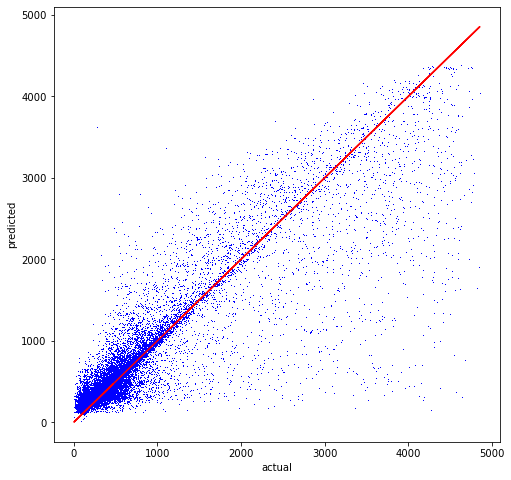

In [93]:
# 
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(test_target, gbr_predicted, ',b')
# Lay on top ideal line of true = predicted
ax.plot(test_target, test_target, '-r')
ax.set_xlabel('actual')
ax.set_ylabel('predicted')
plt.show()

A more even scatter about the red line this time but still a few points where the energy is severely underestimated.

In [95]:
gbr_best.feature_importances_

array([0.10824071, 0.76786754, 0.02610016, 0.02921087, 0.06858072])

In [99]:
# Get the indices in order from highest to lowest importance
ranking = np.argsort(-gbr_best.feature_importances_)

In [106]:
# Reorder the values and feature names by rank
ranked_importances = gbr_best.feature_importances_[ranking]
ranked_features = np.array(features_interest[:-1])[ranking]

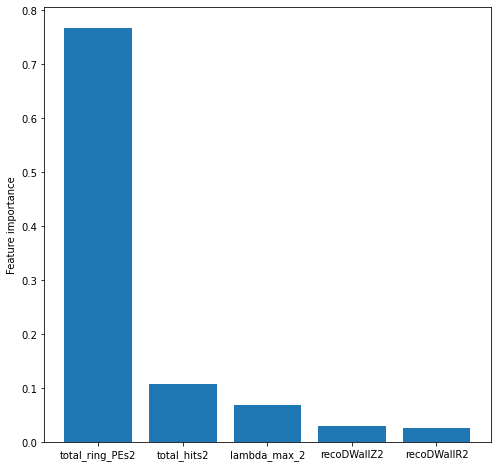

In [110]:
# Bar chart of feature importances
fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(ranked_features,ranked_importances)
ax.set_ylabel('Feature importance')
plt.show()

'total_ring_PEs2' - Number of PMT hits that have been assigned to Cerenkov rings, divided by 4,500 - has by far the greatest impact on the predictive power of the algorithm.